In [1]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [2]:
from src import get_data_loaders

data_dir = os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Corrected')
faste_files_to_load = 3
normalize = False
num_train_val_data = 5000
num_test_data = 1000
sum_threshold = True


train_loader, val_loader, test_loader = get_data_loaders(data_dir,
                                                         faste_files_to_load=faste_files_to_load, 
                                                         normalize=normalize, 
                                                         train_val_data_to_load=num_train_val_data, 
                                                         test_data_to_load=num_test_data,
                                                         sum_threshold=sum_threshold,)


Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Done Loading Data


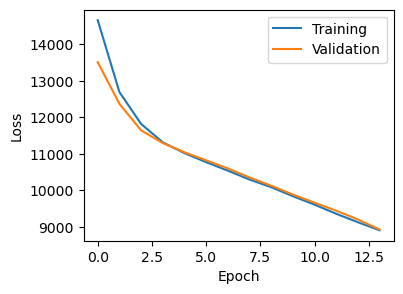

KeyboardInterrupt: 

In [3]:
from src import DNATranformer
from src import train_model

save_dir = os.path.join(os.getcwd(), 'Model_DNATranformer')
os.makedirs(save_dir, exist_ok=True)

num_kernels=[256, 128, 64] # [32,16,8]
kernel_size=[128,64,32]
dropout=0
num_tranformer_heads=4
num_transformer_layers=3
model = DNATranformer(num_kernels=num_kernels, 
                kernel_size=kernel_size,
                 dropout=dropout, 
                 transformer_heads=num_tranformer_heads, 
                 transformer_layers=num_transformer_layers, 
                 output_size=faste_files_to_load
                ).to(device)

lr = 0.0001
epochs = 500
patientce = math.inf
log_input = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=log_input, full=True)
train_model(device, train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patientce)

In [4]:
X, y = next(iter(train_loader))
y_pred = model(X.to(device))
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    if log_input:
        y_p = torch.exp(y_p)
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 50.123, 1461.736
1: 62.242, 993.502
2: 19.442, 130.915


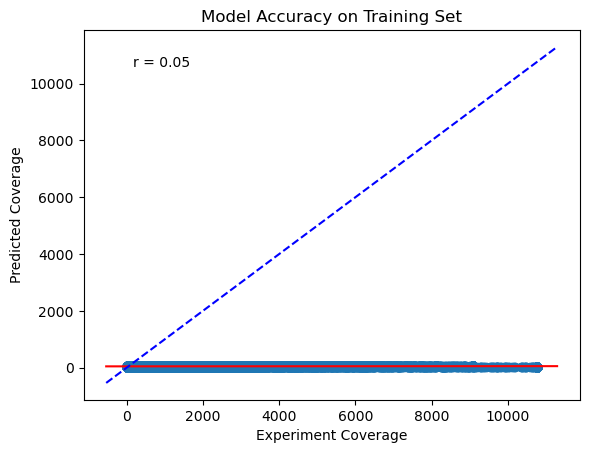

In [5]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Training Set")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TrainingAccuracy.png'), dpi=300)
plt.show()

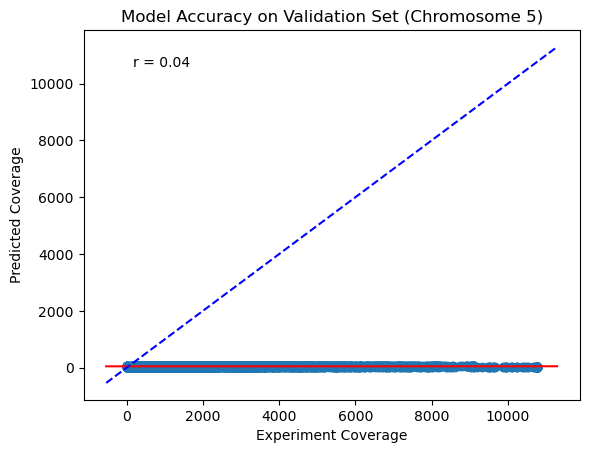

In [6]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)

            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Validation Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'ValAccuracy.png'), dpi=300)
plt.show()

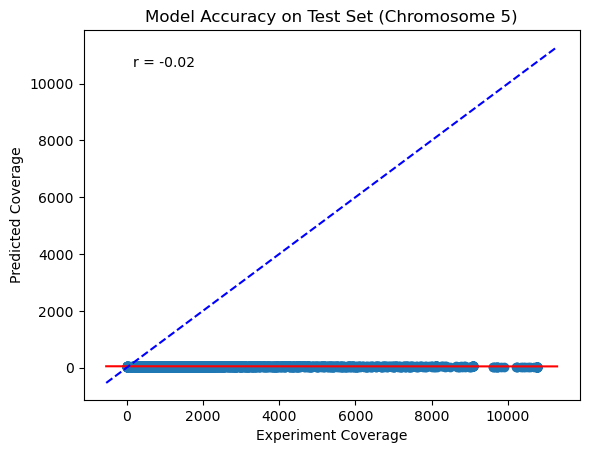

In [7]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TestingAccuracy.png'), dpi=300)
plt.show()